In [1]:
import mlflow
import joblib
import pickle
import os
from hydra import compose, initialize
from hydra.utils import instantiate
import pandas as pd
from ProcessData.dataset import Dataset
from ProcessData.data_splitter import data_splitter
from Evaluate.pips import get_pips_margin
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.calibration import calibration_curve
from sklearn.utils import estimator_html_repr
from sklearn.metrics import brier_score_loss

from Model.SklearnPipeline import CustomPipeline

from my_logger.custom_logger import  logger

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
initialize(config_path="conf/", version_base=None)
cfg = compose(config_name="config.yaml")

In [3]:

data_pipeline = instantiate(cfg.data_pipeline)
df = pd.read_csv(cfg.Data_Source)
df = data_pipeline.apply(df.copy())
dataset = Dataset(data=df, data_splitter=data_splitter)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
dataset.X_train[['Datum','next_close_price1', 'close_price1', 'diff']]

,Datum,next_close_price1,close_price1,diff
395,13.03.2014 05:31:54,1.396,1.394,2.0
6005,09.01.2019 15:34:43,1.150,1.148,2.0
6971,11.06.2020 10:33:17,1.140,1.138,2.0
3191,04.02.2016 16:55:40,1.120,1.116,4.0
2434,13.08.2015 14:43:13,1.112,1.108,4.0
...,...,...,...,...
1274,12.02.2015 15:48:22,1.140,1.138,2.0
2984,09.12.2015 20:43:54,1.100,1.104,-4.0
926,08.12.2014 19:16:00,1.234,1.232,2.0
610,27.08.2014 16:33:05,1.322,1.320,2.0


In [ ]:
dataset.y_train

469     1
6079    1
7045    1
3265    1
2508    1
       ..
1348    1
3058    0
1000    1
684     1
4815    0
Name: y, Length: 5664, dtype: int32

In [ ]:
model_name = 'deploy/model.pkl'

current_directory = os.path.dirname(os.path.realpath('scoring_script.py'))
# Construct the relative path to the model file
model_path = os.path.join(current_directory, model_name)
logger.info(f'Get model from {model_path}')
# Check if the model file exists
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file '{model_name}' not found in the current directory.")

# Load the model
with open (model_path, 'rb') as m:
    model = pickle.load(m)
print(type(model))

2024-02-08 15:23:45,154 - my_logger.custom_logger - INFO - Get model from C:\Users\bartw\Documents\cAlgo\Sources\Robots\Data_Collect_32\Data_Collect_32\deploy/model.pkl
<class 'Model.SklearnPipeline.CustomPipeline'>


In [ ]:
pred = model.predict_proba(dataset.X_oot)

2024-02-08 15:23:45,175 - my_logger.custom_logger - INFO - Selecting features from Dataset
2024-02-08 15:23:45,188 - my_logger.custom_logger - INFO - final cols: Index(['cci1', 'cci10', 'cci100', 'cci101', 'cci102', 'cci103', 'cci104',
       'cci105', 'cci106', 'cci107',
       ...
       'williams90', 'williams91', 'williams92', 'williams93', 'williams94',
       'williams95', 'williams96', 'williams97', 'williams98', 'williams99'],
      dtype='object', length=1341)


In [ ]:
pred

array([[0.42892804, 0.57107196],
       [0.58088377, 0.41911623],
       [0.36441243, 0.63558757],
       ...,
       [0.3193416 , 0.6806584 ],
       [0.36500925, 0.63499075],
       [0.68898416, 0.31101584]])

C:\Users\bartw\AppData\Local\Temp\ipykernel_2884\465720939.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pred[:,1], shade=True)


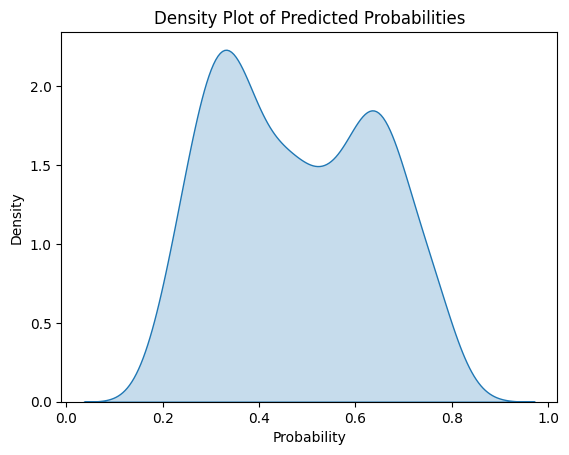

In [ ]:
sns.kdeplot(pred[:,1], shade=True)
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Density Plot of Predicted Probabilities')
plt.show()

C:\Users\bartw\AppData\Local\Temp\ipykernel_2884\3281061894.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pred_0, shade=True)
C:\Users\bartw\AppData\Local\Temp\ipykernel_2884\3281061894.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pred_1, shade=True)


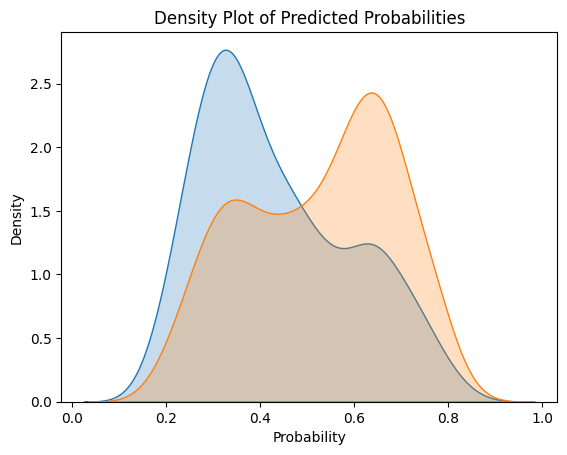

In [ ]:


# Assuming you have some predict_proba results stored in a variable called predict_proba_results
# Replace this with your actual predict_proba results
pred_1 = [x if y > 0.5 else 0 for x, y in zip(pred[:, 1], dataset.y_oot)]
pred_1 = [x for x in pred_1 if x != 0]


pred_0 = [x if y < 0.5 else 0 for x, y in zip(pred[:, 1], dataset.y_oot)]
pred_0 = [x for x in pred_0 if x != 0]

# Create a density plot using seaborn
sns.kdeplot(pred_0, shade=True)
sns.kdeplot(pred_1, shade=True)
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Density Plot of Predicted Probabilities')
plt.show()
